# NSDUH Drug Sequence Analysis Part 4a:  Determine _k_
## Matthew J. Beattie
## University of Oklahoma
__February 3, 2021__

### Clustering
The stability analysis is very resource intense.  So we determine the best number of clusters based upon the inertia of KNN when applied to a sample of the dataset.  This module determines _k_, which will be carried into module 4b.

In [1]:
"""
Import python modules
"""
import pandas as pd
import numpy as np
import copy
import os
import sys
import pathlib, itertools
import time
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import random
from sklearn_extra import cluster as cs
from sklearn.cluster import KMeans
import pickle
import json
import pathutils as pu
from scipy.spatial.distance import euclidean
import mlflow
import mlflow.sklearn
import csv

HOME_DIR = pathlib.Path.home()
CW_DIR = pathlib.Path.cwd()

FIGW = 12
FIGH = 5
FONTSIZE = 8
FIGURESIZE = (FIGW,FIGH)

plt.rcParams['figure.figsize'] = (FIGW, FIGH)
plt.rcParams['font.size'] = FONTSIZE

plt.rcParams['xtick.labelsize'] = FONTSIZE
plt.rcParams['ytick.labelsize'] = FONTSIZE


### Read in model, set file names, etc.

In [2]:
# Set parameters
datapath = 'C:/Users/mjbea/OneDrive/GitHub/abuse_sequence/Data3/'
workingpath = 'C:/Users/mjbea/OneDrive/GitHub/abuse_sequence/Code3/'
outpath = 'C:/Users/mjbea/OneDrive/GitHub/abuse_sequence/Output3/'
year = '2016_2017_2018_2019'
jsondict = datapath + 'NSDUH_field.json'
n_clusters = 11

# Setup filenames
clustpkl = workingpath + 'Kmeans_' + str(n_clusters) + 'clust_' + str(year) + '_nonullpath_clust.pkl'
demogpkl = workingpath + 'Kmeans_' + str(n_clusters) + 'clust_' + str(year) + '_nonullpath_demog.pkl'
modpkl = workingpath + 'Kmeans_' + str(n_clusters) + 'clust_' + str(year) + '_nonullpath_model.pkl'

# Read in cluster and demographic information and the model
dfclust = pd.read_pickle(clustpkl)
dfdemog = pd.read_pickle(demogpkl)
#dfclust = dfclust[['RESPID', 'AFUVECT']]

# Drug name and indices are called by a user-defined function.
ident, rawafuvals, afuvals, drugnames, drugorder, drugnums, drugposition, startdemog, demographics = pu.surveyvars(year)

# Decode dictionaries for NSDUH variables:
f1 = open(jsondict, 'r')
nsduhDecoder = json.load(f1)
f1.close()


### Generate clusters
Generate _B_ cluster sets using KNN on a fraction of the original dataset.  Merge the cluster results back into the original dataset to create a dataframe with the respondent ID, the AFU vector, and the assignments of the observations to cluster sets.

In [3]:
# Set clustering process parameters
B = 20   # Number of models to generate
fraction = 1.0     # Fraction of master dataset to use for input dataset
f = 0.8  # Fraction of input dataset to use for model construction
n_init = 10
max_iter = 1000
tol = 0.0001

# Reduce master dataset if desired and save as an array for KNN
if fraction < 0.9:
    dfclust = dfclust.sample(frac=fraction, replace = False)
allarray = np.array(list(dfclust['AFUVECT']))

inertialist = []
nclustlist = []
meaninertialist = []
starttime = time.time()
for n_clusters in [4,5,6,7,8,9,10,11,12,13,14,15]:
    try:
        for i in range(0,B):
            # Sample the dfclust dataset
            clustsamp = dfclust.sample(frac=f, replace=False)
            clustsamp = clustsamp[['RESPID', 'AFUVECT', 'YRWEIGHT']]

            # Using k-means, generate a model and label the sample dataset
            samparray = np.array(list(clustsamp['AFUVECT']))
            weights = np.array(list(clustsamp['YRWEIGHT']))

            model = KMeans(n_clusters=n_clusters, init='k-means++', n_init=n_init, max_iter=max_iter, 
                           tol=tol, verbose=0, random_state=None, copy_x=True, algorithm='auto')
            model.fit(samparray, sample_weight=weights)
            inertia = model.inertia_
            
            # Apply model to entire dataset to generate clusters
            preds = model.predict(allarray)

            # Add labels to original dataframe
            colname = 'labels_' + str(i)
            dfclust[colname] = preds

            # Calculate inertia of labelled total dataset
            tempdf = dfclust[['AFUVECT','YRWEIGHT']].copy()
            tempdf.loc[:,'labels'] = preds.copy()
            inertialist.append(inertia)
            
            # Show progress
            print('Completed iteration', i, 'of n_clusters', n_clusters)

        meaninertia = np.array(inertialist).mean()
        nclustlist.append(n_clusters)
        meaninertialist.append(meaninertia)

    except:
        print('Clustering process failed --', sys.exc_info()[0], "occurred.")

elapsedtime = time.time() - starttime

Completed iteration 0 of n_clusters 4
Completed iteration 1 of n_clusters 4
Completed iteration 2 of n_clusters 4
Completed iteration 3 of n_clusters 4
Completed iteration 4 of n_clusters 4
Completed iteration 5 of n_clusters 4
Completed iteration 6 of n_clusters 4
Completed iteration 7 of n_clusters 4
Completed iteration 8 of n_clusters 4
Completed iteration 9 of n_clusters 4
Completed iteration 10 of n_clusters 4
Completed iteration 11 of n_clusters 4
Completed iteration 12 of n_clusters 4
Completed iteration 13 of n_clusters 4
Completed iteration 14 of n_clusters 4
Completed iteration 15 of n_clusters 4
Completed iteration 16 of n_clusters 4
Completed iteration 17 of n_clusters 4
Completed iteration 18 of n_clusters 4
Completed iteration 19 of n_clusters 4
Completed iteration 0 of n_clusters 5
Completed iteration 1 of n_clusters 5
Completed iteration 2 of n_clusters 5
Completed iteration 3 of n_clusters 5
Completed iteration 4 of n_clusters 5
Completed iteration 5 of n_clusters 5
Co

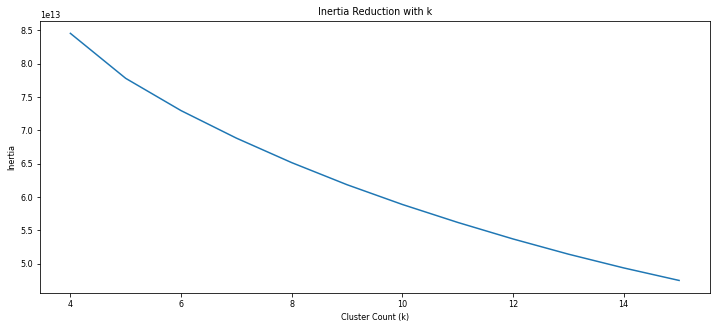

In [4]:
# Check distribution of stability index
#experiment_id = mlflow.create_experiment("Determination of k")
experiment_name = 'Determination of k'
mlflow.set_experiment(experiment_name)
outfile = 'inertia_v_k.txt'

with mlflow.start_run():
        mlflow.log_param("Number of cluster sets", B)
        mlflow.log_param("Fraction of total data used", fraction)
        mlflow.log_param("Sub-fraction used for clustering", f)
        mlflow.log_param('Number of KNN runs', n_init)
        mlflow.log_param('Maximum KNN iterations', max_iter)
        mlflow.log_param('KNN tolerance', tol)

        mlflow.log_metric("Observations", dfclust.shape[0])
        mlflow.log_metric("Runtime", elapsedtime)

        fig = plt.plot(nclustlist, meaninertialist)
        plt.xlabel('Cluster Count (k)')
        plt.ylabel('Inertia')
        plt.title('Inertia Reduction with k')
        plt.savefig('inertia_v_k.png')
        f = open(outfile, 'w')
        print('N-cluster list:', nclustlist, file=f)
        print('Mean inertia list:', meaninertialist, file=f)
        f.close()
        mlflow.log_artifact('inertia_v_k.png')
        mlflow.log_artifact('inertia_v_k.txt')
mlflow.end_run()